Loading the IMDB dataset

In [19]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  17.3M      0  0:00:04  0:00:04 --:--:-- 18.1M


**Setting the data**

In [20]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    if not os.path.exists(val_dir / category):
        os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size, validation_split=0.01, subset="training", seed=1337
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size, validation_split=0.999, subset="validation", seed=1337
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Using 19800 files for training.
Found 20000 files belonging to 2 classes.
Using 19980 files for validation.
Found 25000 files belonging to 2 classes.


Preparing integer sequence datasets

In [21]:
from tensorflow.keras import layers

max_length = 150
max_tokens = 10000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4).take(100)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4).take(10000)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

Sequence model on one-hot encoded vectors

In [22]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 10000)       0         
                                                                 
 bidirectional (Bidirection  (None, 64)                2568448   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2568513 (9.80 MB)
Trainable params: 2568513 (9.80 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

Training a basic sequence

Epoch 1/10
100/100 [==============================] - 11s 62ms/step - loss: 0.6919 - accuracy: 0.5259 - val_loss: 0.6885 - val_accuracy: 0.5871
Epoch 2/10
100/100 [==============================] - 5s 55ms/step - loss: 0.6323 - accuracy: 0.6606 - val_loss: 0.5718 - val_accuracy: 0.7613
Epoch 3/10
100/100 [==============================] - 5s 54ms/step - loss: 0.4887 - accuracy: 0.7937 - val_loss: 0.4678 - val_accuracy: 0.7920
Epoch 4/10
100/100 [==============================] - 5s 54ms/step - loss: 0.3751 - accuracy: 0.8616 - val_loss: 0.4552 - val_accuracy: 0.7992
Epoch 5/10
100/100 [==============================] - 5s 54ms/step - loss: 0.3086 - accuracy: 0.8941 - val_loss: 0.4423 - val_accuracy: 0.8146
Epoch 6/10
100/100 [==============================] - 5s 54ms/step - loss: 0.2450 - accuracy: 0.9275 - val_loss: 0.3877 - val_accuracy: 0.8357
Epoch 7/10
100/100 [==============================] - 5s 53ms/step - loss: 0.1934 - accuracy: 0.9422 - val_loss: 0.4933 - val_accuracy: 0.782

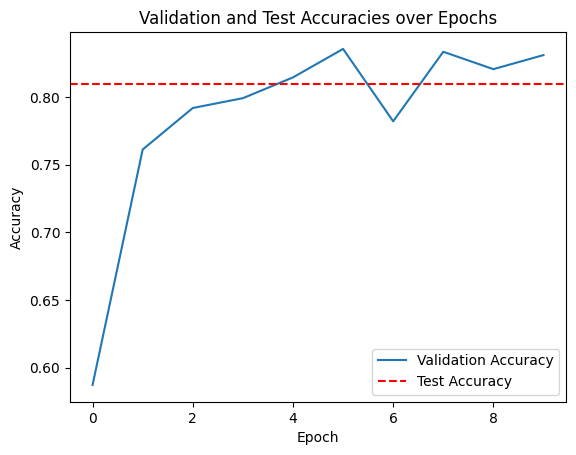

In [23]:
!pip install matplotlib
import tensorflow.keras as keras
import matplotlib.pyplot as plt

# Assume model is defined already
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

# Loading the best model
model = keras.models.load_model("one_hot_bidir_lstm.keras")

# Evaluating the model on test set
test_loss, test_accuracy = model.evaluate(int_test_ds)

# Printing the validation and test accuracy
print(f"Validation accuracy: {history.history['val_accuracy'][-1]:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")

# Plotting accuracies
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracies over Epochs')
plt.legend()
plt.show()

Putting an example of an embedding layer

In [24]:
from tensorflow.keras import layers
max_tokens = 10000
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

Building model that uses embedding layer from the scratch

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  10.6M      0  0:00:07  0:00:07 --:--:-- 13.3M
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                           

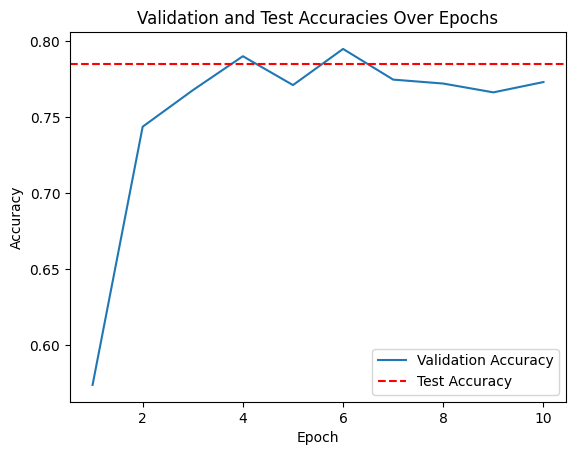

In [25]:
import os
import pathlib
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Downloading the datasets
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

# Defining directories to the paths
base_dir = pathlib.Path("aclImdb")
train_dir = base_dir / "train"
test_dir = base_dir / "test"

# Creating the training, validation and test datasets
batch_size = 32
max_length = 150
max_tokens = 10000

# Training dataset
train_ds = keras.utils.text_dataset_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode="binary",
)

# Validation dataset
val_ds = keras.utils.text_dataset_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode="binary",
)

# Test dataset
test_ds = keras.utils.text_dataset_from_directory(
    directory=test_dir,
    batch_size=batch_size,
    label_mode="binary",
)

# Defining datasets of integer sequence
text_only_train_ds = train_ds.map(lambda x, y: x)

# Preparing datasets of integer sequence
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
).take(100)

int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
).take(10000)

int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
).take(10000)

# Model definition
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

# Model training
callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

# Loading the best model and evaluating on the testing set
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

# Extracting accuracies from past
val_acc = history.history['val_accuracy']
test_acc = model.evaluate(int_test_ds)[1]

# Plotting
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracies Over Epochs')
plt.legend()
plt.show()

Enabling masking on embedding layer

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

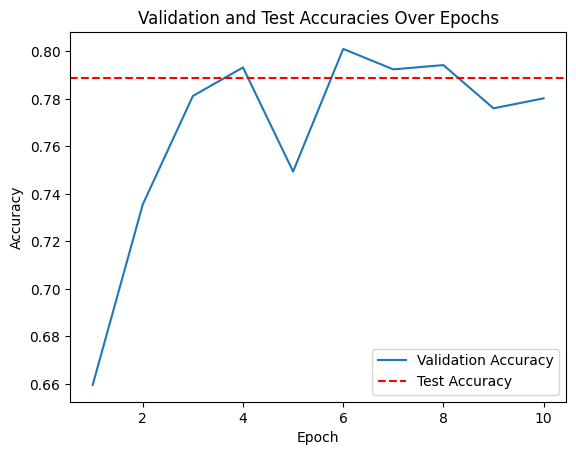

In [26]:
import matplotlib.pyplot as plt

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

# Extracting accuracies from past
val_acc = history.history['val_accuracy']
test_acc = model.evaluate(int_test_ds)[1]

# Plotting
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracies Over Epochs')
plt.legend()
plt.show()

Pretrained embeddings

In [27]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-05-05 05:11:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-05-05 05:11:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-05-05 05:11:46--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Parsing the pretrained GloVe word-embeddings

In [28]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


Preparing the matrix

In [29]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

Model of pretrained embedding layer

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         1000000   
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                34048     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1034113 (3.94 MB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________

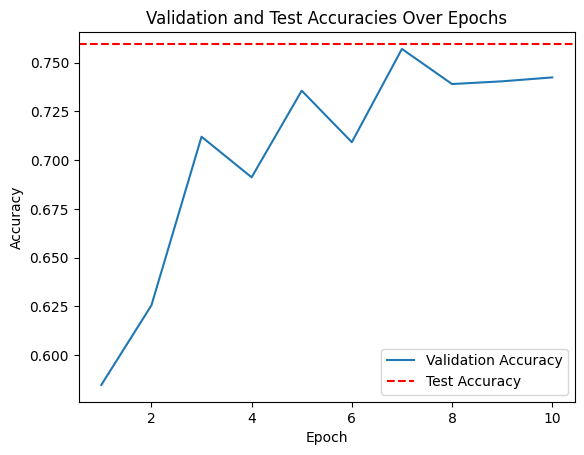

In [30]:
import matplotlib.pyplot as plt

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

# Extracting accuracies from the past
val_acc = history.history['val_accuracy']
test_acc = model.evaluate(int_test_ds)[1]

# Plotting
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracies Over Epochs')
plt.legend()
plt.show()

Finding out to determine the number of traing samples at which point the embedding layer gives better performance

In [31]:
import os
import pathlib
import random
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

Downloading and loading the data

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

In [32]:
#Defining directories to the paths
base_dir = pathlib.Path("aclImdb")
train_dir = base_dir / "train"
test_dir = base_dir / "test"

#Creating training, validation and testing datasets
batch_size = 32
max_length = 150
max_tokens = 10000

# Training dataset
train_ds = keras.utils.text_dataset_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode="binary",
)

# Validation dataset
val_ds = keras.utils.text_dataset_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode="binary",
)

# Test dataset
test_ds = keras.utils.text_dataset_from_directory(
    directory=test_dir,
    batch_size=batch_size,
    label_mode="binary",
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Defining datasets of integer sequence

In [33]:
text_only_train_ds = train_ds.map(lambda x, y: x)

Preparing datasets of integer sequence

In [34]:
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

Defining the embedding layer

In [35]:
embedding_dim = 100
path_to_glove_file = "glove.6B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))
embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

Defining architecture of the model with one-hot encoding

In [36]:
def get_one_hot_model():
    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = tf.one_hot(inputs, depth=max_tokens)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

Defining architecture of the model with pretrained word embeddings

In [37]:
def get_embedding_model():
    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

Training and evaluating model with change in number of training samples

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  22.7M      0  0:00:03  0:00:03 --:--:-- 22.7M
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Number of training samples: 100
Validation accuracy: 0.765
Test accuracy: 0.754

Number of training samples: 500
Validation accuracy: 0.843
Test accuracy: 0.825

Number of training samples: 1000
Validation accuracy: 0.842
Test accuracy: 0.828

Number of training samples: 2000
Validation accuracy: 0.845
Test accuracy: 0.833

Number of training samples: 5000
Validation accuracy: 0.857
Test accuracy: 0.835

Number of training samples: 10000
Validation accuracy: 0.854
Test accuracy: 0.834



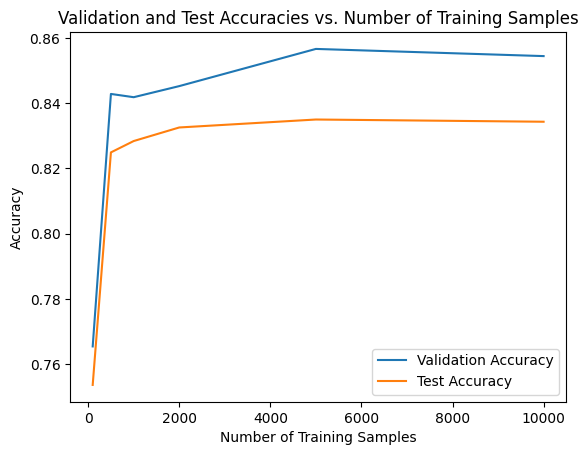

In [38]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Defining the different number of samples to try
num_training_samples = [100, 500, 1000, 2000, 5000, 10000]

# Defining constants
max_length = 150
max_tokens = 10000
batch_size = 32

# Load the dataset
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

# Load the dataset
train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size, validation_split=0.2, subset="training", seed=1337
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size, validation_split=0.2, subset="validation", seed=1337
)

text_only_train_ds = train_ds.map(lambda x, y: x)

# Preparing the vectorization layer
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

val_accuracies = []
test_accuracies = []

# Repeating different numbers of training samples
for num_samples in num_training_samples:
    # Prepare the integer sequence datasets
    int_train_ds = train_ds.map(
        lambda x, y: (text_vectorization(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    ).take(num_samples)
    int_val_ds = val_ds.map(
        lambda x, y: (text_vectorization(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Let's define the model
    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

    # Train the model
    model.fit(int_train_ds, validation_data=int_val_ds, epochs=5, verbose=0)

    # Evaluate the model on validation and test sets
    val_accuracy = model.evaluate(int_val_ds, verbose=0)[1]
    test_accuracy = model.evaluate(int_test_ds, verbose=0)[1]

    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)

    # Results
    print(f"Number of training samples: {num_samples}")
    print(f"Validation accuracy: {val_accuracy:.3f}")
    print(f"Test accuracy: {test_accuracy:.3f}")
    print()

# Plotting
plt.plot(num_training_samples, val_accuracies, label='Validation Accuracy')
plt.plot(num_training_samples, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracies vs. Number of Training Samples')
plt.legend()
plt.show()